In [726]:
import numpy
from data.data_utils import load_dataset



In [727]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pdb import set_trace

# Q1 K-NN for Regression

In [ ]:
np.random.seed(42)

## Useful functions

In [728]:
# Get RMSE
def RMSE(y, y_hat):
  return np.sqrt(np.mean(np.square(y-y_hat)))

In [729]:
def knn_regressor(x_train, y_train, x_test, k = 1, metric = "minkowski_2") -> np.array:
    """
    Find the k-th closest data points along x axis and take the average of their y values.
    Do that for all testing data and return the predicted y values.
    """
    y_test = np.zeros((x_test.shape[0], 1))
    # print(y_test.shape)
    for i, x_test_i in enumerate(x_test):
        if metric == "minkowski_2":
          dist = np.sqrt(np.sum(np.square(x_train-x_test_i.reshape((1,-1))), axis=1))
        elif metric == "minkowski_1":
          dist = np.sum(np.abs(x_train-x_test_i.reshape((1,-1))), axis=1)
        else:
            pass
        i_nn = np.argpartition(dist, kth=k, axis=0)[:k]
        # k=5: i_nn=[122 384  90 399  40] etc
        # compute the mean of these nearest neighbours
        y_test[i,0] = np.mean(y_train[i_nn, 0])
    # y_test: [[mean y for x_test_1], [mean y for x_test_2], [mean y for x_test_3]] ...
    return y_test

def knn_cross_validation(x, y, x_test, dataset, metrics, v = 5) -> np.array:
    """
    Cross validation to find the y_test,
    Return k_vals, best, fold_i[np.argmin(best)], k_merged_prediction
    k_vals : list of all k we tried
    best : list of lowest RMSE for each k values
    fold_i[np.argmin(best)] : the fold index with the lowest RMSE value
    k_merged_prediction : predictions merged from cross-validation for each k value
    """
    # Create shuffling indices for training data
    n = x.shape[0]

    # Initialize mrse returned array
    rmse = []
    # rmse[:] = np.nan
    # print(type(mrse))
    if dataset == "mauna_loa" and metrics == "minkowski_2": # plot the training data in the first figure
        plt.figure(figsize=(7,7))
        plt.plot(x.squeeze(), y.squeeze(), 'k', label='Exact', alpha=0.5)

    # Create random k value
    min_k = dict(rosenbrock=1,  pumadyn32nm=22, mauna_loa=1)  # specify minimum k value to consider in the search
    max_k = dict(rosenbrock=10, pumadyn32nm=26, mauna_loa=30) # specify maximum k value to consider in the search
    # Define a range of k
    k_vals = np.arange(min_k[dataset], max_k[dataset]+1, dtype=int)
    # print(k_vals)
    
    # print("predictions", predictions.shape)
    for k in k_vals:
        predictions = np.zeros(n)
        # predictions[:] = np.nan
        val_err_in_fold = []
        # val_err_in_fold[:] = np.nan
        five_fold = np.array([0,1,2,3,4])
        for i_split in range(v):
            train_fold = np.delete(five_fold, i_split)
            print("train_fold", train_fold)
            # Initialize prediction array
            idx_cv = -np.ones(int(5*np.ceil(n/5)), dtype=int) # round up to the nearest factor of 5
            idx_cv[:n] = np.arange(x.shape[0], dtype=int) # add the indicies of all points
            idx_cv = np.random.permutation(idx_cv).reshape((5, -1))
            idx_cv = idx_cv[idx_cv>=0]
            idx_cv = np.array_split(idx_cv, 5)
            # print("k: %d; fold: %d; idx_cv:"%(k, i_split))
            # print(idx_cv)
            split_train = np.concatenate([idx_cv[i] for i in train_fold])
            
            split_valid = idx_cv[i_split]
            print("len:", len(split_train), len(split_valid))

            x_valid = x[split_valid]
            # print("split valid", len(split_valid))
            # print("y", y.shape)
            y_valid = y[split_valid]
            # print("k", k)
            # print("split valid", split_valid)
            # print("split train", split_train)
            # print("x", x[split_train])
            predictions[split_valid] = knn_regressor(x_train=x[split_train], y_train=y[split_train], 
                                                        x_test=x_valid, k=k, metric=metrics).squeeze()

        

            # print("dim valid", y_valid.squeeze().shape)
            # print("dim pred", predictions.shape)
            val_err = RMSE(y=y_valid.squeeze(), y_hat=predictions[split_valid])
            val_err_in_fold.append(val_err)
        # print("k", k, val_err_in_fold)
        rmse.append(val_err_in_fold)
        if dataset == 'mauna_loa' and k in [2, 22] and metrics == "minkowski_2":
            plt.plot(x.squeeze(), predictions, label='k=%d validation prediction'%k)
            plt.legend(loc=0)
            plt.xlabel("date")
            plt.ylabel("CO2")
            plt.title("Mauna Loa Cross-validation predictions (Minkowski 2)")
    print("mse", np.asarray(rmse))
    rmse = np.asarray(rmse)
    fold_i = rmse.argmin(axis=1)
    best = rmse.min(axis=1)
    # print("best",best)
    return k_vals, best, fold_i[np.argmin(best)]

## Mauna Loa

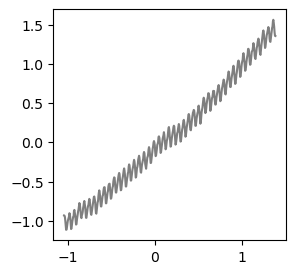

In [730]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

# Visualize our data
plt.figure(figsize=(3,3))
plt.plot(x_train.squeeze(), y_train.squeeze(), 'k', label='Exact', alpha=0.5)

In [731]:
# Shuffle
# idx = np.ones(x.shape[0])
idx = np.arange(x.shape[0], dtype=int)
idx = np.random.permutation(idx)
idx = np.array_split(idx, 5)
len(idx[4])

131

In [732]:
np.random.seed(42)
# Split the data
x_train_folds = np.array_split(x, 5)
y_train_folds = np.array_split(y, 5)

In [733]:
a = [1,2,3]
b = np.array([[4],[5],[6],[7]])
bb = np.zeros((y.shape[0], 1))

for i in range(bb.shape[0]):
    bb[i,0]=np.mean(y_train[b, 0])

b[1,0]

5

train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 

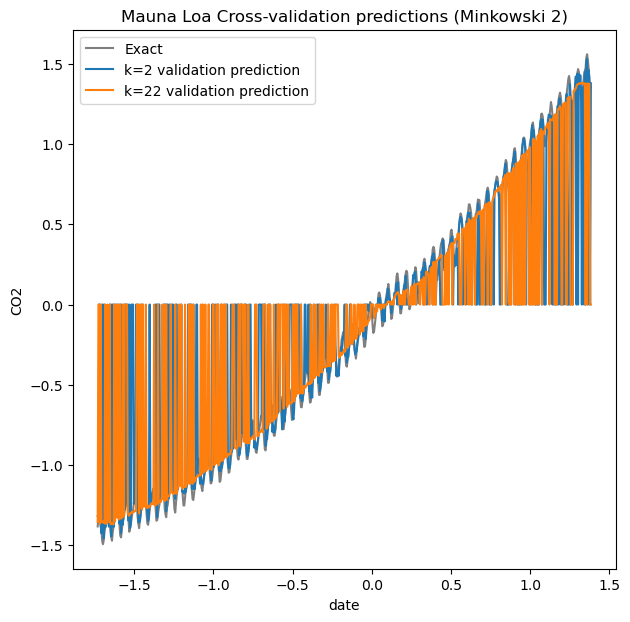

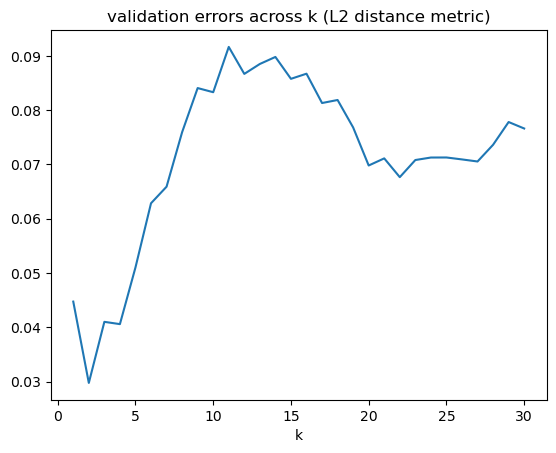

In [734]:
k_vals, best2, fold_2 = knn_cross_validation(x, y, x_test, "mauna_loa", v = 5, metrics = "minkowski_2")

plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2)

# print(k_vals,best2,fold_2)


In [735]:
# rmse = [[1,2,3],[4,5,6]]
# rmse_max = [max(r) for r in rmse]
# rmse_max

train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
train_fold [1 2 3 4]
len: 524 132
train_fold [0 2 3 4]
len: 525 131
train_fold [0 1 3 4]
len: 525 131
train_fold [0 1 2 4]
len: 525 131
train_fold [0 1 2 3]
len: 525 131
mse [[0.0484699  0.04772737 0.04732853 0.05088221 0.04742708]
 [0.03425318 0.03208056 0.02643264 0.04060556 0.03143554]
 [0.03741154 0.04106342 0.04470847 0.04581635 0.04234029]
 [0.04490375 0.04180243 0.0425328  0.04574276 0.04619267]
 [0.05729278 0.0577243  0.05676525 0.05788513 0.06147057]
 [0.06452251 0.06381393 0.06446872 0.06471063 0.06289089]
 [0.06933711 0.07223379 0.06828729 0

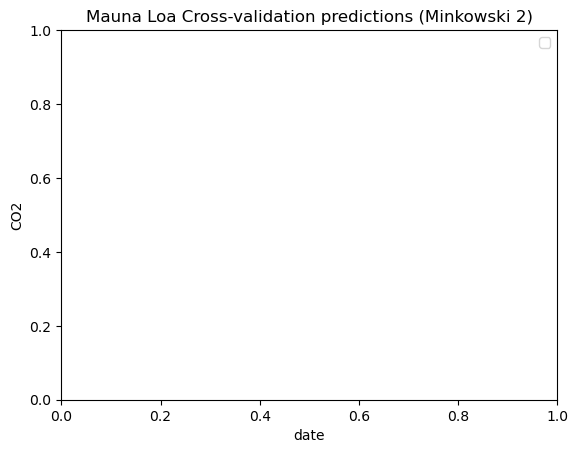

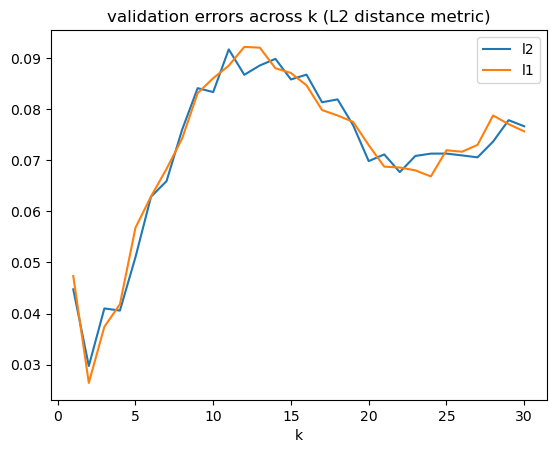

In [736]:
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "mauna_loa", v = 5, metrics = "minkowski_1")
# best = [ err * 30 ]
# Show validation errors for both metrics
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2, label = "l2")
plt.plot(k_vals, best1, label = "l1")
plt.legend()
plt.show()

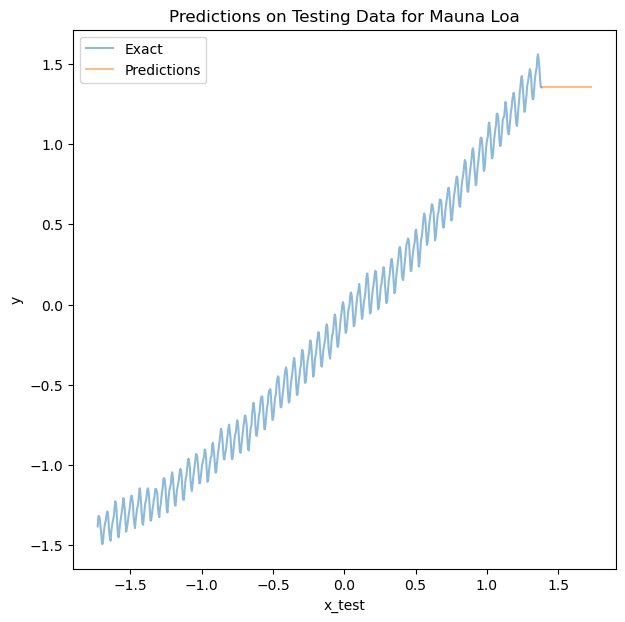

In [737]:
# Plot Prediction Curves for several k values
y_test_pred = knn_regressor(x, y, x_test, k = 1, metric = "minkowski_2")

plt.figure(figsize=(7,7))
plt.title('Predictions on Testing Data for Mauna Loa')
plt.ylabel('y')
plt.xlabel('x_test')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), y_test_pred.squeeze(), label='Predictions', alpha=0.5)
plt.legend()
plt.show()

In [738]:
idx1 = np.argmin(best1)
idx2 = np.argmin(best2)
p = np.argmin([best1[idx1], best2[idx2]]) + 1
if p == 2:
    k = idx2+1
    print("Metric Minkowski with p = %d at k = %d %dth fold has the lowest validation error %f." %(p, k, fold_2+1, best2[idx2]))
else:
    k = idx1+1
    print("Metric Minkowski with p = %d at k = %d %dth fold has the lowest validation error %f." %(p, k, fold_1+1, best1[idx1]))

# Find test error
def k_nn_test_error(x_train, y_train, x_test, y_test, k, metric) -> np.array:
    predictions = knn_regressor(x_train=x_train, y_train=y_train, 
                                                        x_test=x_test, k=k, metric=metric).squeeze()
            # print(predictions)
            # print("dim valid", y_valid.squeeze().shape)
            # print("dim pred", predictions.shape)
    test_err = RMSE(y=y_test.squeeze(), y_hat=predictions)
    
    return predictions, test_err
m = "minkowski_" + str(p)
predictions, test_err = k_nn_test_error(x, y, x_test, y_test, k = k, metric = m)
print("The test error for the best model is: %f" %(test_err))
test_err


Metric Minkowski with p = 1 at k = 2 3th fold has the lowest validation error 0.026433.
The test error for the best model is: 0.440705


0.44070489035463933

In [739]:
x_valid.shape

(145, 1)

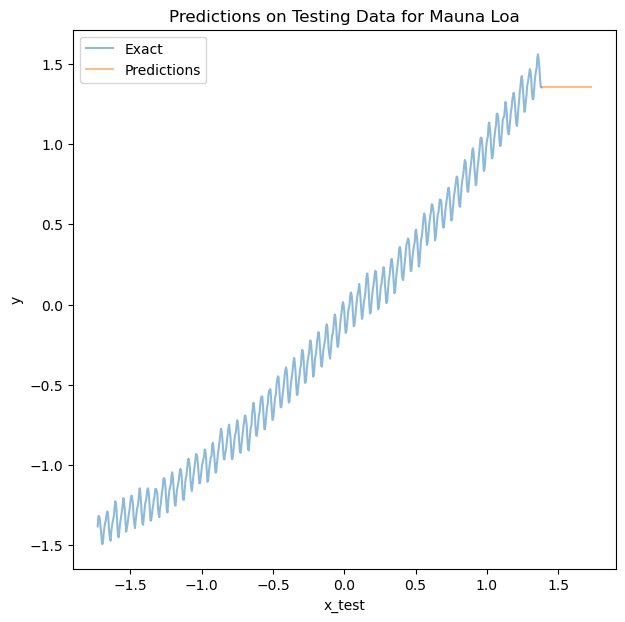

In [740]:
# Visualize our data
plt.figure(figsize=(7,7))
plt.title('Predictions on Testing Data for Mauna Loa')
plt.ylabel('y')
plt.xlabel('x_test')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), predictions.squeeze(), label='Predictions', alpha=0.5)
plt.legend()
plt.show()

## Rosenbrock, n_train=1000, d=2

In [741]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)


In [742]:
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

# # Visualize our data
# plt.figure(figsize=(3,3))
# plt.plot(x_train.squeeze(), y_train.squeeze(), 'k', label='Exact', alpha=0.5)

train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
mse [[0.21097405 0.1987143  0.52616923 0.15181086 0.56838762]
 [0.35346537 0.29108508 0.26832684 0.30619808 0.25131579]
 [0.61141375 0.32222323 0.34084713 0.34068283 0.33998251]
 [0.57829182 0.24629986 0.33439844 0.54036143 0.20602407]
 [0.55164528 0.44171132 0.59884492 0.35601707 0.42739088]
 [0.14315053 0.39039602 0.48926951 0.44456899 0.27906502]
 [0.10277817 0.72600939 0.10408862 0.47802579 0.21066956]
 [0.12295309 0.26292857 0.16643577 0.59354251 0.18673714]
 [0.13159669 0.24018719 0.24882613 0.27417042 0.73389342]
 [0.4821675  0.59879121 0.31755634 0.22963384 0.72993969]]
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600 400
train_fold [0 1 2 4]
len: 1600 400
train_fold [0 1 2 3]
len: 1600 400
train_fold [1 2 3 4]
len: 1600 400
train_fold [0 2 3 4]
len: 1600 400
train_fold [0 1 3 4]
len: 1600

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mse [[0.52545573 0.20022047 0.56803377 0.2856035  0.23115533]
 [0.30850067 0.23142563 0.39113137 0.24774188 0.32338952]
 [0.21209548 0.53011169 0.30154946 0.2630931  0.15428291]
 [0.15457154 0.27731535 0.14963597 0.34087741 0.56192456]
 [0.46124757 0.25248428 0.37657454 0.25046096 0.23134102]
 [0.39979348 0.63798625 0.3134019  0.66695489 0.6419634 ]
 [0.41838705 0.49211927 0.4895836  0.61860019 0.13698642]
 [0.46759825 0.26393445 0.17543132 0.51952303 0.61161696]
 [0.41527914 0.36403104 0.47520336 0.58271146 0.28711216]
 [0.24365835 0.25315741 0.4097167  0.44620284 0.30089018]]


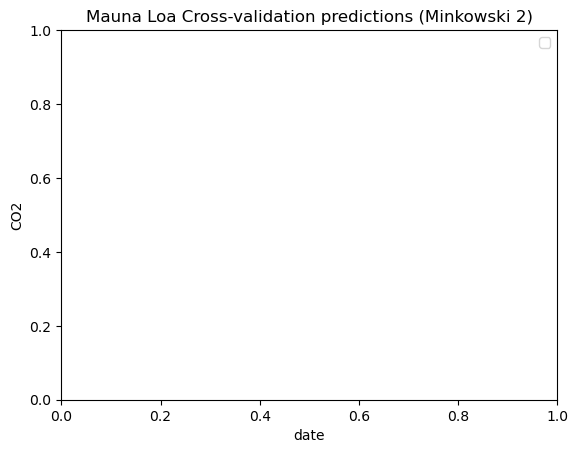

In [743]:
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "rosenbrock", v = 5, metrics = "minkowski_1")
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "rosenbrock", v = 5, metrics = "minkowski_1")

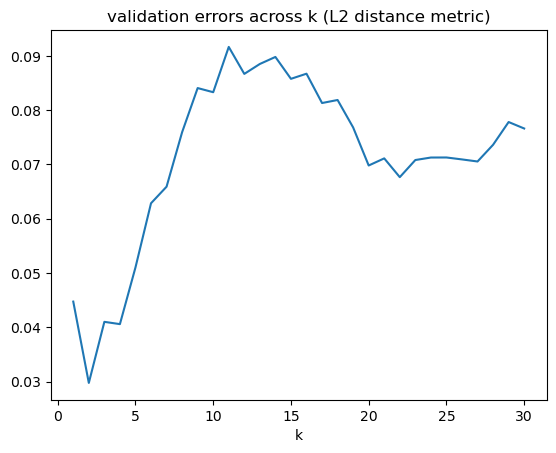

In [744]:
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2)
